In [1]:
import torch
from torch.nn import Module, Linear, Conv2d, MaxPool2d, LeakyReLU, Sequential, BatchNorm2d, Sigmoid, ConvTranspose2d
from torch import nn
from generators import Generator, Discriminator

In [2]:
imgf = Generator()(torch.randn(10, 100,1,1))
Discriminator()(imgf).shape

torch.Size([10, 1])

In [4]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ConvertImageDtype, Compose, Normalize, ToTensor

img_transforms = Compose([
    PILToTensor(),
    ConvertImageDtype(torch.float),
    # Normalize(mean=(0.5), std=(0.5))
])

root_dir = './data/mnist/'
train_dataset = MNIST(root=root_dir+'train', train=True, download=True, transform=img_transforms)
test_dataset = MNIST(root=root_dir+'test', train=False, download=True, transform=img_transforms)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=20)


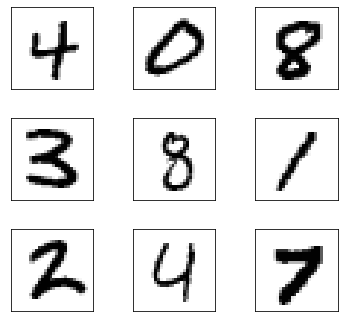

In [9]:
#show some images
from utils_gen import plot_images
plot_images(train_loader)

In [6]:
nn.Tanh()(torch.tensor(-10))
#6013383838

(tensor(0.9961), tensor(0.))

In [7]:
def sample_from_latent(n_samples):
    return torch.randn(size=(n_samples, 100, 1, 1))

#### Train Deep Convolutional GAN on MNIST

* Instantiate the generator and discriminator
* Create the optimizers
* Create the loss functions
* Iterate over the batches of the dataloarder
* Update the weights (optimizer step)
* Compute the losses and generate images

In [8]:
from tqdm.auto import tqdm
from torch.nn import BCEWithLogitsLoss

bce = BCEWithLogitsLoss()
def compute_loss(pred, target):
    return bce(pred, target)
      
 
class Trainner():
    def __init__(self, generator, discriminator, train_loader, test_loader):
        self.generator = generator
        self.discriminator = discriminator
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.losses = []
        self.losses_gen = []

        self.discriminator.to(self.device)
        self.generator.to(self.device)

        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=1e-4)
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=1e-4)

    def discriminator_step(self, img_batch, labels_batch):
        self.optimizer_D.zero_grad()

        ones = torch.ones(labels_batch.shape).to(self.device)
        zeros = torch.zeros(labels_batch.shape).to(self.device)
        z_input = sample_from_latent(img_batch.shape[0]).to(self.device)

        img_batch = img_batch.to(self.device)
        fake_imgs = self.generator(z_input)

        y_pred = self.discriminator(img_batch)
        y_pred_fake = self.discriminator(fake_imgs)

        loss = compute_loss(y_pred, ones)
        loss += compute_loss(y_pred_fake, zeros)
        loss.backward()

        self.optimizer_D.step()        

        return loss.cpu().item()

    def generator_step(self, labels_batch, img_batch):
        self.optimizer_G.zero_grad()

        ones = torch.ones(labels_batch.shape).to(self.device)
        z_input = sample_from_latent(img_batch.shape[0]).to(self.device)

        fake_imgs = self.generator(z_input)
        y_pred_fake = self.discriminator(fake_imgs)
        loss = compute_loss(y_pred_fake, ones)
        loss.backward()

        self.optimizer_G.step()
        return loss.cpu().item()    


    def train_both(self, epochs = 1, train_gen_every = 1, train_dis_every = 1):
        progress_bar = tqdm(range(epochs*len(train_loader)))
        for epoch in range(epochs):
            self.discriminator.train()
            self.generator.train()
            for iter, (img_batch, labels_batch) in enumerate(train_loader):
                if iter % train_dis_every == 0:
                    d_loss = self.discriminator_step(img_batch, labels_batch)
                if iter % train_gen_every == 0:
                    g_loss = self.generator_step(labels_batch, img_batch)

                progress_bar.update(1)
                if d_loss:
                    self.losses.append(d_loss)
                if g_loss:
                    self.losses_gen.append(g_loss)
            print("Epoch: {} - D loss: {} - G loss: {}".format(epoch, d_loss, g_loss))        
                


In [9]:
trainer = Trainner(Generator(), Discriminator(), train_loader, test_loader)

In [10]:
torch.randn(size=(32, 100, 1, 1)).to(torch.device('cuda'))

tensor([[[[ 1.7800]],

         [[ 2.1813]],

         [[-1.5506]],

         ...,

         [[-0.9183]],

         [[-0.0029]],

         [[ 0.4468]]],


        [[[ 0.6894]],

         [[-1.8254]],

         [[ 1.2858]],

         ...,

         [[ 0.5016]],

         [[-0.7105]],

         [[ 0.6125]]],


        [[[ 2.1698]],

         [[-1.2928]],

         [[-0.8346]],

         ...,

         [[-0.5440]],

         [[-0.1486]],

         [[-0.1295]]],


        ...,


        [[[ 0.6625]],

         [[ 0.6842]],

         [[ 0.1332]],

         ...,

         [[-0.1350]],

         [[-0.7408]],

         [[ 1.1685]]],


        [[[ 0.5258]],

         [[ 0.2942]],

         [[ 0.5359]],

         ...,

         [[ 0.0281]],

         [[-0.9997]],

         [[ 0.2904]]],


        [[[-0.5986]],

         [[-2.5119]],

         [[-1.2556]],

         ...,

         [[-0.6616]],

         [[-1.7131]],

         [[-0.1274]]]], device='cuda:0')

In [10]:
trainer.train_both(epochs=20, train_gen_every=1, train_dis_every=10)

  0%|          | 0/18760 [00:00<?, ?it/s]

Epoch: 0 - D loss: 2.6666674613952637 - G loss: 0.24912267923355103
Epoch: 1 - D loss: 2.1447341442108154 - G loss: 0.4788554310798645


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

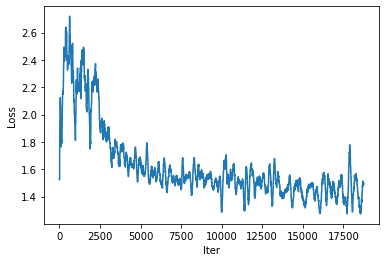

In [32]:
#plot losses
plt.plot(trainer.losses)
plt.xlabel('Iter')
plt.ylabel('Loss')


Text(0, 0.5, 'Loss')

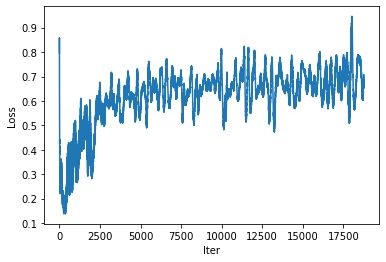

In [33]:
#plot losses
plt.plot(trainer.losses_gen)
plt.xlabel('Iter')
plt.ylabel('Loss')


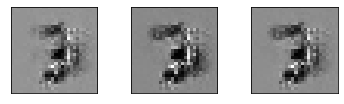

In [56]:
trainer.generator.eval()
z_input = sample_from_latent(3).to(trainer.device)
fake_imgs = trainer.generator(z_input)
img0 = fake_imgs.detach().cpu().numpy()


#Show images
plt.figure(figsize=(5,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    plt.imshow(img0[i].reshape(28,28), cmap='binary', interpolation='none')
    plt.xticks([])
    plt.yticks([])

In [1416]:
trainer.generator

Generator(
  (sequential): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Tanh()
  )
)

In [1418]:
trainer.generator(z_input).shape

torch.Size([3, 1, 28, 28])

In [30]:
trainer.discriminator

Discriminator(
  (sequential): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)